# Topic Modeling

# 1 - Coleta de dados - twitter scrape
# 2 - Pré-processamento de texto
# 3 - Visualizando palavras-chave na nuvem de palavras
# 4 - Modelo LDA de treinamento
# 5 - Visualizando tópicos

In [1]:
#!pip install twitterscraper

In [2]:
from twitterscraper import query_tweets
import pandas as pd
import re, pickle, os
import datetime 
import nltk
from nltk.util import ngrams
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords, wordnet 
from collections import Counter 
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
from gensim.corpora import MmCorpus
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim

INFO: {'User-Agent': 'Mozilla/5.0 (Windows; U; Windows NT 6.1; x64; fr; rv:1.9.2.13) Gecko/20101203 Firebird/3.6.13'}


In [3]:
additional_stop_words=['hrtechconf','peopleanalytics','hrtech','hr','hrconfes',
                       'hrtechnology','voiceofhr','hrtechadvisor','gen','wait',
                       'next','see','hcm','booth','tech','la','vega','last',
                       'look','technology','work', 'announce','product','new',
                       'team','use','happen','time','take','make','everyone',
                       'anyone','week','day','year','let','go','come','word',
                       'employee','get','people','today','session','need',
                       'meet','help','talk','join','start','awesome','great',
                       'achieve','job','tonight','everyday','room','ready',
                       'one','company','say','well','data','share','love',
                       'want','like','good','business','sure','miss','demo',
                       'live','min','play','always','would','way','almost',
                       'thank','still','many','much','info','wow','play','full',
                       'org','create','leave','back','front','first','may',
                       'tomorrow','yesterday','find','stay','add','conference',
                       'top','stop','expo','hall','detail','row','award','hey',
                       'continue','put','part','whole','some','any','everywhere',
                       'convention','center','forget','congratulation','every',
                       'agenda','gift','card','available','behind','meeting',
                       'best','happen','unlockpotentialpic','half','none',
                       'human', 'resources','truly','win','possible','thanks',
                       'know','check','visit','fun','give','think','forward',
                       'twitter','com','pic','rt','via']

In [4]:
FIGURE_PATH = r'./figures/'
DATA_PATH = r'./data/'
MODEL_PATH = r'./models/'
WORDCLOUD_FILE = FIGURE_PATH + 'wordcloud.png'
WORD_COUNT_FILE = FIGURE_PATH + 'commond_words_freq.png'
TOPIC_VIS_FILE = FIGURE_PATH + 'lda.html'
ORIG_TWEET_FILE = DATA_PATH + 'all_tweets'
CLEANED_TWEET_FILE = DATA_PATH + 'tweets_cleaned_df'
CORPUS_FILE = MODEL_PATH + 'clean_tweets_corpus.mm'
DICT_FILE = MODEL_PATH + 'clean_tweets.dict'
LDA_MODEL_FILE = MODEL_PATH + 'tweets_lda.model'
LDA_TOPICS_FILE = MODEL_PATH + 'tweets_lda_topics.txt'

In [5]:
# Search tweets that have keyword HRTechConf in English
TWEET_QUERY = 'HRTechConf'
BEGINDATE = datetime.date(2019, 9, 26)
ENDDATE = datetime.date(2019, 10, 6)
LANG = 'en'
# ngrams or multi-word expressions
NUM_GRAMS = 2
# ----------------------
# LDA model parameters
# ----------------------
# Number of topics
NUM_TOPICS = 30
# Number of training passes
NUM_PASSES = 50 
# Document-Topic Density. The lower alpha is, the more likely that 
# a document may contain mixture of just a few of the topics. 
# Default is 1.0/NUM_TOPICS
ALPHA = 0.001
# Word-Topic Density. The lower eta is, the more likely that 
# a topic may contain a mixture of just a few of the words
# Default is 1.0/NUM_TOPICS
ETA = 'auto'

In [6]:
def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Tokenização: dividindo frases em palavras

In [7]:
def text_cleanup(text):  
    '''
    Text pre-processing
        return tokenized list of cleaned words
    '''
    # Convert to lowercase
    text_clean = text.lower()
    # Remove non-alphabet
    text_clean = re.sub(r'[^a-zA-Z]|(\w+:\/\/\S+)',' ', text_clean).split()    
    # Remove short words (length < 3)
    text_clean = [w for w in text_clean if len(w)>2]
    # Lemmatize text with the appropriate POS tag
    lemmatizer = WordNetLemmatizer()
    text_clean = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text_clean]
    # Filter out stop words in English 
    stops = set(stopwords.words('english')).union(additional_stop_words)
    text_clean = [w for w in text_clean if w not in stops]
    
    return text_clean

In [8]:
def wordcloud(word_count_df):
    '''
    Create word cloud image
    '''
    # Convert DataFrame to Map so that word cloud can be generated from freq
    word_count_dict = {}
    for w, f in word_count_df.values:
        word_count_dict[w] = f
    # Generate word cloud 
    wordcloud = WordCloud(max_words=300, width=1400, height=900, 
                          random_state=12, contour_width=3, 
                          contour_color='firebrick')
    wordcloud.generate_from_frequencies(word_count_dict)
    plt.figure(figsize=(10,10), facecolor='k')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    # Save the word cloud image
    wordcloud.to_file(WORDCLOUD_FILE) 
    print ('Word cloud saved\n')
    plt.close('all')
    
    return wordcloud

In [9]:
def read_data_from_pickle(infile):
    with open (infile, 'rb') as fp:
        return pickle.load(fp)

In [10]:
def save_data_to_pickle(outfile, all_tweets):
    with open(outfile, 'wb') as fp:
        pickle.dump(all_tweets, fp)

In [11]:
def save_print_to_file(outfile, msg):
    with open(outfile, 'w') as fp:
        print(msg, file=fp) 

# TwitterScraper  coleta tweets

Referencia https://github.com/taspinar/twitterscraper

In [12]:
def get_all_tweets():
    '''
    Extract all tweets or load from a saved file
    '''
    if os.path.isfile(ORIG_TWEET_FILE):        
        tweets_df = read_data_from_pickle(ORIG_TWEET_FILE)  
        print('Loaded tweet extracts from file\n')
    else:
        print('Start scraping tweets from twitter.com...\n')
        # https://twitter.com/search-advanced
        list_of_tweets = query_tweets(
                                      TWEET_QUERY, 
                                      begindate=BEGINDATE, 
                                      enddate=ENDDATE, 
                                      lang=LANG
                                     )
        # Convert list of tweets to DataFrame
        tweets_df = pd.DataFrame([vars(x) for x in list_of_tweets])
        # Save tweet extracts to file
        save_data_to_pickle(ORIG_TWEET_FILE, tweets_df)
        print ('Tweet extracts saved\n')        
    
    return tweets_df

# Pré-processamento de Texto

In [13]:
# 1 - Converter todas as palavras em minúsculas
# 2 - Remover caracteres não alfabéticos
# 3 - Remover palavra curta (comprimento menor que 3)
# 4 - Tokenização: dividindo frases em palavras
# 5 - Marcação de parte da fala (POS): processo de classificação de palavras em sua categoria gramatical, a fim de entender seus papéis em uma frase, por exemplo, verbos, substantivos, adjetivos, etc. A marcação de PDV fornece contexto gramatical para lematização.
# 6 - Lematização: convertendo uma palavra para sua forma básica, por exemplo , carro , carros e carros em carros
# 7 -Remova palavras comuns em inglês, por exemplo, a, the, of, etc., e remova palavras comuns que agregam muito pouco valor à nossa análise, por exemplo, hrtechconf, much, hr, get, etc.

In [17]:
def preprocess_tweets(all_tweets_df):
    '''
    Preprocess tweets
    '''
    if os.path.isfile(CLEANED_TWEET_FILE):
        # Read cleaned tweets from saved file
        cleaned_tweets_df = read_data_from_pickle(CLEANED_TWEET_FILE)
        print('Loaded cleaned tweets from file\n')
    else:
        print('Start preprocessing tweets ...\n')
        # dataframe to add parsed tweets 
        cleaned_tweets_df = all_tweets_df.copy(deep=True)
        # parsing tweets 
        cleaned_tweets_df['token'] = [text_cleanup(x) for x in all_tweets_df['text']]     
        # Save cleaned tweets to file
        save_data_to_pickle(CLEANED_TWEET_FILE, cleaned_tweets_df)
        print ('Cleaned tweets saved\n')
    
    return cleaned_tweets_df 

In [18]:
#mostrar exemplo do que foi tokenizado


# Contagem de palavras e nuvem de palavras

In [19]:
def get_word_count(tweets_text, num_gram):
    '''
    Get common word counts
    '''
    n_grams = list(ngrams(tweets_text, num_gram))
    common_words = Counter(n_grams).most_common()
    word_count = pd.DataFrame(data = common_words, 
                              columns=['word','frequency']) 
    # Convert list to string
    word_count['word'] = word_count['word'].apply(' '.join)
    # Plot word count graph
    word_count.head(20).sort_values('frequency').plot.barh(
            x='word', y='frequency', title='Word Frequency',figsize=(19,10))
    plt.savefig(WORD_COUNT_FILE)
    print ('Word count saved\n')
    plt.close('all')
    
    return word_count

# Bag of Words (Bigrams)

In [20]:

## Tamanho dos n-grams min1 e max 2
def word_grams(words, min=1, max=2):
    '''
    Build ngrams word list
    '''
    word_list = []
    for n in range(min, max):
        for ngram in ngrams(words, n):
            word_list.append(' '.join(str(i) for i in ngram))
    return word_list

# Topic Modeling Via LDA

# Número de tópicos: 

# Alfa (densidade do tópico do documento) : 

# Eta (densidade do tópico do Word)

# Número de passes 

In [21]:
def train_lda_model(token_tweets):
    print('Start LDA model training ...\n')    
    # Build dictionary
    tweets_dict = corpora.Dictionary(token_tweets)
    # Remove words that occur less than 10 documents, 
    # or more than 50% of the doc
    tweets_dict.filter_extremes(no_below=10, no_above=0.5)
    # Transform doc to a vectorized form by computing frequency of each word
    bow_corpus = [tweets_dict.doc2bow(doc) for doc in token_tweets]
    # Save corpus and dictionary to file
    MmCorpus.serialize(CORPUS_FILE, bow_corpus)
    tweets_dict.save(DICT_FILE)
    
    # Create tf-idf model and then apply transformation to the entire corpus
    tfidf = models.TfidfModel(bow_corpus)
    tfidf_corpus = tfidf[bow_corpus]
    
    # Train LDA model
    lda_model = models.ldamodel.LdaModel(corpus=tfidf_corpus, 
                                         num_topics=NUM_TOPICS, 
                                         id2word=tweets_dict, 
                                         passes=NUM_PASSES, 
                                         alpha=ALPHA, 
                                         eta=ETA,
                                         random_state=49)
    # Save LDA model to file
    lda_model.save(LDA_MODEL_FILE)
    print ('LDA model saved\n')
    
    # Save all generated topics to a file
    msg = ''
    for idx, topic in lda_model.print_topics(-1):
        msg += 'Topic: {} \nWords: {}\n'.format(idx, topic)    
    save_print_to_file(LDA_TOPICS_FILE, msg)
    
    # Evaluate LDA model performance
    eval_lda (lda_model, tfidf_corpus, tweets_dict, token_tweets)    
    # Visualize topics
    vis_topics(lda_model, tfidf_corpus, tweets_dict)
    return lda_model
        

# Visualização de Tópicos

In [22]:
def eval_lda (lda_model, corpus, dict, token_text):
    # Compute Perplexity: a measure of how good the model is. lower the better.
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=token_text, 
                                         dictionary=dict, coherence='c_v')   
    print('\nCoherence: ', coherence_model_lda.get_coherence())

In [23]:
def vis_topics(lda_model, corpus, dict):
    '''
    Plot generated topics on an interactive graph
    '''
    lda_data =  pyLDAvis.gensim.prepare(lda_model, corpus, dict, mds='mmds')
    pyLDAvis.display(lda_data)
    pyLDAvis.save_html(lda_data, TOPIC_VIS_FILE)
    print ('Topic visual saved\n')

In [24]:
# if __name__ == '__main__':
#     # Get all tweets
#     #all_tweets_df = get_all_tweets()
#     # Preprocess tweets
#     cleaned_tweets_df = preprocess_tweets(all_tweets_df)   
#     # Convert series to list for word count
# #     tweets_text = [word for one_tweet in cleaned_tweets_df['token'] for word in one_tweet]
#     # Get common ngrams word count
# #     word_count_df = get_word_count(tweets_text, num_gram=NUM_GRAMS)    
#     # Generate word cloud
# #     tweets_wordcloud = wordcloud(word_count_df)  
#     # Generate ngram tokens
# #     cleaned_tweets_df['ngram_token'] = [word_grams(x, NUM_GRAMS, NUM_GRAMS+1) for 
# #                      x in cleaned_tweets_df['token']]
#     # Train LDA model and visualize generated topics
# #     lda_model = train_lda_model(cleaned_tweets_df['ngram_token'])
#     print('DONE!')

In [26]:
#1 

# cleaned_tweets_df

In [27]:
#2
all_tweets_df = get_all_tweets()

Start scraping tweets from twitter.com...



INFO: queries: ['HRTechConf since:2019-09-26 until:2019-09-27', 'HRTechConf since:2019-09-27 until:2019-09-28', 'HRTechConf since:2019-09-28 until:2019-09-29', 'HRTechConf since:2019-09-29 until:2019-09-30', 'HRTechConf since:2019-09-30 until:2019-10-01', 'HRTechConf since:2019-10-01 until:2019-10-02', 'HRTechConf since:2019-10-02 until:2019-10-03', 'HRTechConf since:2019-10-03 until:2019-10-04', 'HRTechConf since:2019-10-04 until:2019-10-05', 'HRTechConf since:2019-10-05 until:2019-10-06']
INFO: Querying HRTechConf since:2019-09-26 until:2019-09-27
INFO: Querying HRTechConf since:2019-09-28 until:2019-09-29
INFO: Querying HRTechConf since:2019-09-27 until:2019-09-28
INFO: Querying HRTechConf since:2019-09-30 until:2019-10-01
INFO: Querying HRTechConf since:2019-09-29 until:2019-09-30
INFO: Querying HRTechConf since:2019-10-01 until:2019-10-02
INFO: Querying HRTechConf since:2019-10-03 until:2019-10-04
INFO: Querying HRTechConf since:2019-10-02 until:2019-10-03
INFO: Querying HRTechCon

INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgLa57ZTv3yAWgMC0scSr8N8gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-03%20until%3A2019-10-04&l=en
INFO: Using proxy 103.21.161.202:35101
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwLXtlLuW2SAWhMCm4cejsNkgEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-09-28%20until%3A2019-09-29&l=en
INFO: Using proxy 103.21.161.202:35101
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgLWtl-iK4iAWgoC3-cnGt-IgEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-05%20until%3A2019-10-06&l=en
INFO: Using proxy 103.

INFO: Using proxy 154.7.2.79:3129
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgLfJz-Lq1yAWgMC0_Z3Ok9ggEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-09-27%20until%3A2019-09-28&l=en
INFO: Using proxy 154.7.2.79:3129
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCgL216drZ4SAWgoC3-cnGt-IgEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-05%20until%3A2019-10-06&l=en
INFO: Using proxy 154.7.8.201:3129
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCgLfJ8Mrm2CAWhMCm4cejsNkgEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-09-28%20until%3A2019-09-29&l=

INFO: Using proxy 211.244.224.130:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwKbluL-i3SAWgIC9kfzypt0gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-01%20until%3A2019-10-02&l=en
INFO: Using proxy 154.7.2.242:3129
INFO: Twitter returned : 'has_more_items' 
INFO: Got 109 tweets for HRTechConf%20since%3A2019-09-28%20until%3A2019-09-29.
INFO: Got 198 tweets (109 new).
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgLWFp4Th2yAWgMCqhYvXgdwgEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-09-30%20until%3A2019-10-01&l=en
INFO: Using proxy 211.244.224.130:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entit

INFO: Using proxy 101.109.255.48:50620
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCwLXlpaDX2yAWgMCqhYvXgdwgEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-09-30%20until%3A2019-10-01&l=en
INFO: Using proxy 217.8.227.22:54993
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwLS50tPG1yAWgMC0_Z3Ok9ggEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-09-27%20until%3A2019-09-28&l=en
INFO: Using proxy 217.8.227.22:54993
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaIwLThuKnA3iAWgICjma3Xy94gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-02%20until%3A201

INFO: Using proxy 103.94.0.82:49241
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwLrRhYXK2yAWgMCqhYvXgdwgEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-09-30%20until%3A2019-10-01&l=en
INFO: Using proxy 189.204.241.44:56792
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgLvp0ODi3yAWgMC0scSr8N8gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-03%20until%3A2019-10-04&l=en
INFO: Using proxy 103.94.0.82:49241
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaIwLyBjc273iAWgICjma3Xy94gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-02%20until%3A2019-

INFO: Using proxy 151.80.36.115:1080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwL7RrcmX3SAWgIC9kfzypt0gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-01%20until%3A2019-10-02&l=en
INFO: Using proxy 151.80.36.115:1080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwLzp-cLW4CAWgIC2paO2kuEgEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-04%20until%3A2019-10-05&l=en
INFO: Using proxy 159.192.97.181:23500
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgLfl7Miu2yAWgMCqhYvXgdwgEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-09-30%20until%3A201

INFO: Using proxy 115.79.24.188:38702
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgKeJl7GT3SAWgIC9kfzypt0gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-01%20until%3A2019-10-02&l=en
INFO: Using proxy 193.33.241.61:45837
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaEgLbx_euk4CAWgIC2paO2kuEgEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-04%20until%3A2019-10-05&l=en
INFO: Using proxy 115.79.24.188:38702
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwKaN2tDT3yAWgMC0scSr8N8gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-03%20until%3A20

INFO: Using proxy 46.24.85.74:37745
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwL7RhJCt3iAWgICjma3Xy94gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-02%20until%3A2019-10-03&l=en
INFO: Using proxy 179.108.169.71:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgKaB9ovM3yAWgMC0scSr8N8gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-03%20until%3A2019-10-04&l=en
INFO: Using proxy 179.108.169.71:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaEgL3ZjMCH3SAWgIC9kfzypt0gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-01%20until%3A2019

INFO: Using proxy 64.137.110.249:3121
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgKah46bH3yAWgMC0scSr8N8gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-03%20until%3A2019-10-04&l=en
INFO: Using proxy 64.137.110.249:3121
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwL7V-vmm3iAWgICjma3Xy94gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-02%20until%3A2019-10-03&l=en
INFO: Using proxy 41.217.217.1:55866
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgKap_9f-3CAWgIC9kfzypt0gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-01%20until%3A201

INFO: Using proxy 87.99.93.100:43944
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCwKOZ9qz63CAWgIC9kfzypt0gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-01%20until%3A2019-10-02&l=en
INFO: Using proxy 200.205.21.66:8081
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgLaRl7--3yAWgMC0scSr8N8gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-03%20until%3A2019-10-04&l=en
INFO: Using proxy 200.205.21.66:8081
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwLq93Zej3iAWgICjma3Xy94gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-02%20until%3A2019-

INFO: Using proxy 64.137.110.236:3121
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwKadgtid3iAWgICjma3Xy94gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-02%20until%3A2019-10-03&l=en
INFO: Using proxy 167.88.117.209:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwKONp7e53yAWgMC0scSr8N8gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-03%20until%3A2019-10-04&l=en
INFO: Using proxy 167.88.117.209:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgKON1ISd3iAWgICjma3Xy94gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-02%20until%3A20

INFO: Using proxy 46.45.129.16:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCwLXp-dSt3yAWgMC0scSr8N8gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-03%20until%3A2019-10-04&l=en
INFO: Using proxy 46.45.129.16:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCgLu5xfru3CAWgIC9kfzypt0gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-01%20until%3A2019-10-02&l=en
INFO: Using proxy 46.45.129.16:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaEwLXd3_GY3iAWgICjma3Xy94gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-02%20until%3A2019-10-

INFO: Using proxy 136.228.128.164:53052
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgLuNpsb93iAWgMC0scSr8N8gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-03%20until%3A2019-10-04&l=en
INFO: Using proxy 208.180.237.55:31012
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaEgLu9_PeU3iAWgICjma3Xy94gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-02%20until%3A2019-10-03&l=en
INFO: Using proxy 103.241.204.225:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCwKOdqdvp3CAWgIC9kfzypt0gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-01%20until%

INFO: Got 1501 tweets for HRTechConf%20since%3A2019-10-03%20until%3A2019-10-04.
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaGgL2J2paS3iAWgICjma3Xy94gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-02%20until%3A2019-10-03&l=en
INFO: Using proxy 58.65.128.234:35614
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwLT5prTb3CAWgIC9kfzypt0gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-01%20until%3A2019-10-02&l=en
INFO: Using proxy 5.140.233.194:45752
INFO: Got 3213 tweets (1501 new).
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwLyd1tKR3iA

INFO: Using proxy 94.74.172.87:80
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwL6F19bQ3SAWgICjma3Xy94gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-02%20until%3A2019-10-03&l=en
INFO: Using proxy 94.74.172.110:80
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaIgLbJpYbF3SAWgICjma3Xy94gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-02%20until%3A2019-10-03&l=en
INFO: Using proxy 94.74.184.28:80
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgLex7Ou53SAWgICjma3Xy94gEjUAFQAlAFUAFQAA&q=HRTechConf%20since%3A2019-10-02%20until%3A2019-10-03&l=

Tweet extracts saved



In [28]:
#3

cleaned_tweets_df = preprocess_tweets(all_tweets_df)
cleaned_tweets_df.token[1]

Start preprocessing tweets ...

Cleaned tweets saved



['bryq',
 'scientifically',
 'validate',
 'pre',
 'hire',
 'assessment',
 'remove',
 'bias',
 'recruiting',
 'process',
 'increase',
 'hire',
 'diversity',
 'technologypic',
 'itx',
 'rji']

In [29]:
cleaned_tweets_df.head()

,has_media,hashtags,img_urls,is_replied,is_reply_to,likes,links,parent_tweet_id,replies,reply_to_users,...,text,text_html,timestamp,timestamp_epochs,tweet_id,tweet_url,user_id,username,video_url,token
0,False,[HRTechConf],[],False,False,4,[https://twitter.com/WorkForceSW/status/117653...,,0,[],...,Looking forward to #HRTechConf this week! http...,"<p class=""TweetTextSize js-tweet-text tweet-te...",2019-09-29 23:42:23,1569800543,1178455011292057600,/jennifer_wolf/status/1178455011292057600,301077299,Jennifer Wolf,,[]
1,True,"[HRTechConf, hr, technologypic]",[https://pbs.twimg.com/media/EFqs7Q4X0AAUGkh.jpg],False,False,1,[],,0,[],...,Bryq is a scientifically validated pre-hire as...,"<p class=""TweetTextSize js-tweet-text tweet-te...",2019-09-29 23:00:11,1569798011,1178444388483174400,/BryqHR/status/1178444388483174400,1125745760723771394,Bryq,,"[bryq, scientifically, validate, pre, hire, as..."
2,False,[HRTechConf],[],True,False,10,[https://twitter.com/SteveBoese/status/1178019...,,1,[],...,Looking forward to HR Tech family reunion week...,"<p class=""TweetTextSize js-tweet-text tweet-te...",2019-09-29 22:58:44,1569797924,1178444026141401089,/TiffanyAppleby/status/1178444026141401089,21020659,Tiffany Appleby,,"[family, reunion]"
3,False,[HRTechConf],[],True,False,8,[],,1,[],...,"That thing, when you have just finished packin...","<p class=""TweetTextSize js-tweet-text tweet-te...",2019-09-29 22:45:32,1569797132,1178440700922335233,/mollielombardi/status/1178440700922335233,18191723,Mollie Lombardi,,"[thing, finish, pack, exit, triumphantly, spil..."
4,False,[1953],[],False,False,2,[https://victorhrconsultant.com/2019/09/20/joi...,,0,[],...,Come meet Victor @ThisWayGlobal booth #1953 at...,"<p class=""TweetTextSize js-tweet-text tweet-te...",2019-09-29 22:13:21,1569795201,1178432601587159040,/angelahood90/status/1178432601587159040,74334667,angela,,"[victor, thiswayglobal, oct, victorassad]"


In [30]:
#4

tweets_text = [word for one_tweet in cleaned_tweets_df['token'] for word in one_tweet]

In [34]:
print(len(tweets_text))
print(tweets_text[1])

59346
scientifically


In [35]:
#5


word_count_df = get_word_count(tweets_text, num_gram=NUM_GRAMS)

Word count saved



In [36]:
word_count_df.head()

,word,frequency
0,josh bersin,276
1,adp platform,80
2,platform earn,75
3,earn recognition,75
4,talent acquisition,69


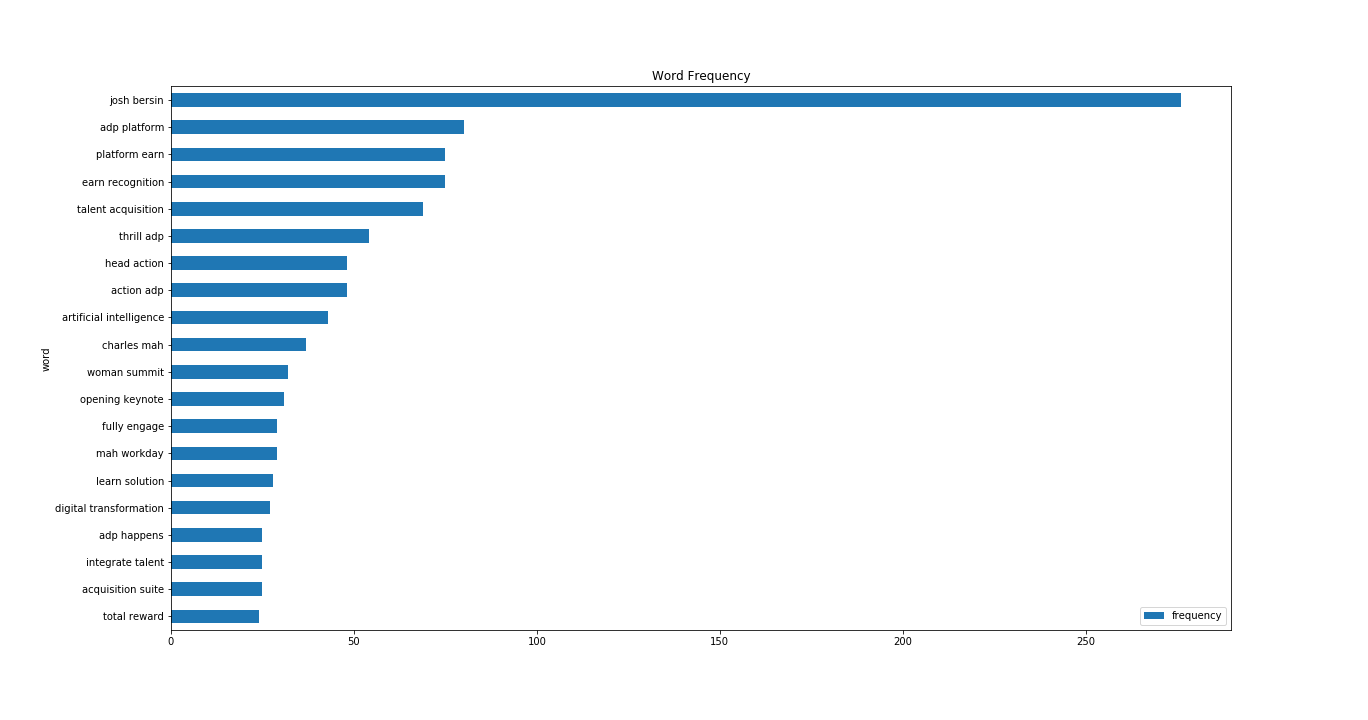

In [37]:
from IPython.display import display, Image
display(Image(filename='figures/commond_words_freq.png'))

In [40]:
#6




tweets_wordcloud = wordcloud(word_count_df) 

Word cloud saved



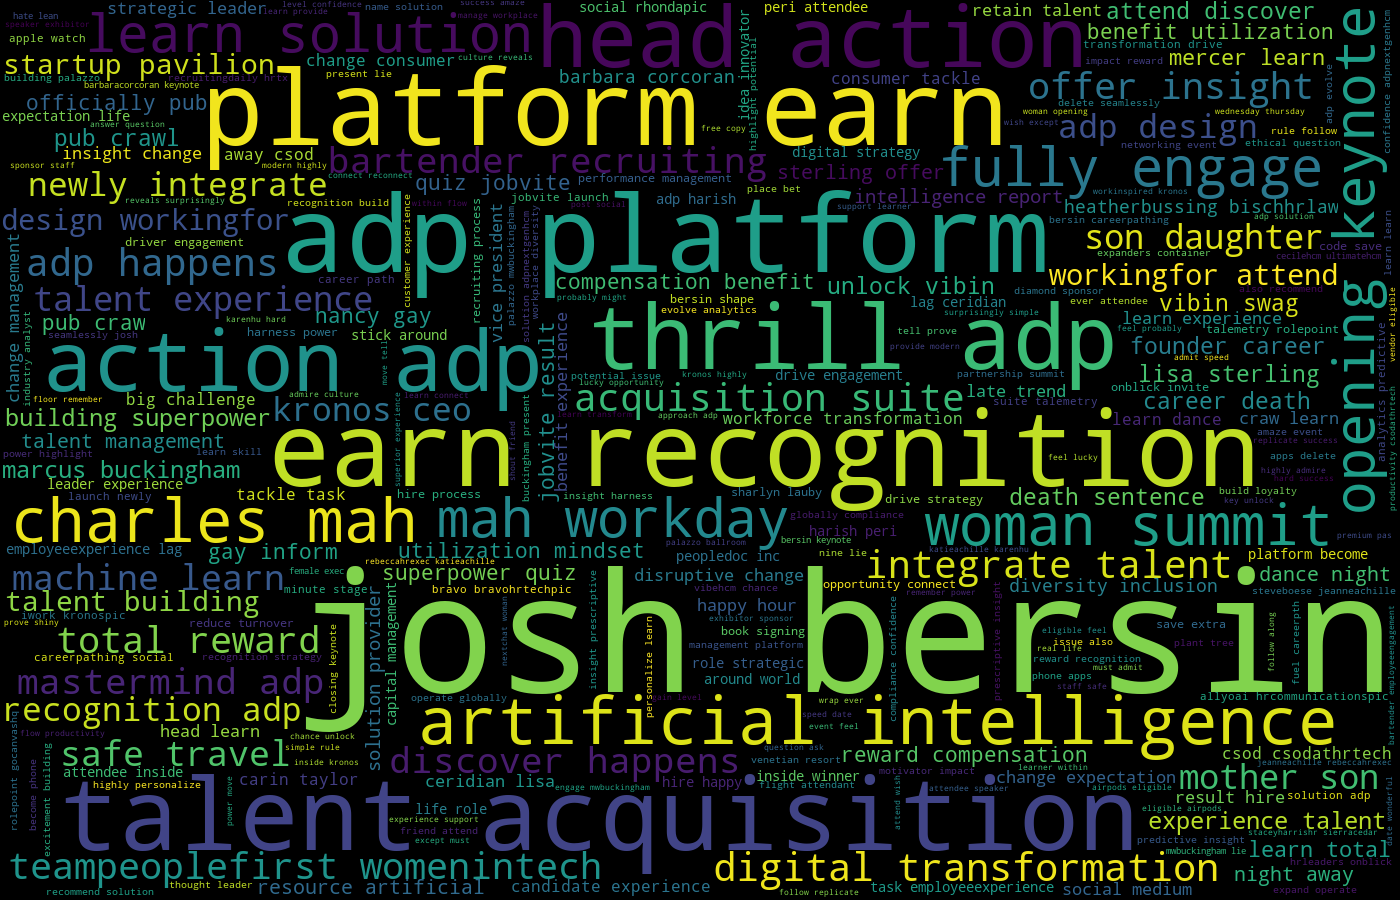

In [41]:

from IPython.display import display, Image
display(Image(filename='figures/wordcloud.png'))

In [42]:
#7




cleaned_tweets_df['ngram_token'] = [word_grams(x, NUM_GRAMS, NUM_GRAMS+1) for 
                x in cleaned_tweets_df['token']]

In [43]:
cleaned_tweets_df.head()

,has_media,hashtags,img_urls,is_replied,is_reply_to,likes,links,parent_tweet_id,replies,reply_to_users,...,text_html,timestamp,timestamp_epochs,tweet_id,tweet_url,user_id,username,video_url,token,ngram_token
0,False,[HRTechConf],[],False,False,4,[https://twitter.com/WorkForceSW/status/117653...,,0,[],...,"<p class=""TweetTextSize js-tweet-text tweet-te...",2019-09-29 23:42:23,1569800543,1178455011292057600,/jennifer_wolf/status/1178455011292057600,301077299,Jennifer Wolf,,[],[]
1,True,"[HRTechConf, hr, technologypic]",[https://pbs.twimg.com/media/EFqs7Q4X0AAUGkh.jpg],False,False,1,[],,0,[],...,"<p class=""TweetTextSize js-tweet-text tweet-te...",2019-09-29 23:00:11,1569798011,1178444388483174400,/BryqHR/status/1178444388483174400,1125745760723771394,Bryq,,"[bryq, scientifically, validate, pre, hire, as...","[bryq scientifically, scientifically validate,..."
2,False,[HRTechConf],[],True,False,10,[https://twitter.com/SteveBoese/status/1178019...,,1,[],...,"<p class=""TweetTextSize js-tweet-text tweet-te...",2019-09-29 22:58:44,1569797924,1178444026141401089,/TiffanyAppleby/status/1178444026141401089,21020659,Tiffany Appleby,,"[family, reunion]",[family reunion]
3,False,[HRTechConf],[],True,False,8,[],,1,[],...,"<p class=""TweetTextSize js-tweet-text tweet-te...",2019-09-29 22:45:32,1569797132,1178440700922335233,/mollielombardi/status/1178440700922335233,18191723,Mollie Lombardi,,"[thing, finish, pack, exit, triumphantly, spil...","[thing finish, finish pack, pack exit, exit tr..."
4,False,[1953],[],False,False,2,[https://victorhrconsultant.com/2019/09/20/joi...,,0,[],...,"<p class=""TweetTextSize js-tweet-text tweet-te...",2019-09-29 22:13:21,1569795201,1178432601587159040,/angelahood90/status/1178432601587159040,74334667,angela,,"[victor, thiswayglobal, oct, victorassad]","[victor thiswayglobal, thiswayglobal oct, oct ..."


In [44]:
#8




lda_model = train_lda_model(cleaned_tweets_df['ngram_token'])

Start LDA model training ...

LDA model saved


Perplexity:  -383.2651793876157

Coherence:  0.532060037670753


/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Topic visual saved

